# Introduction


NLP goes viral in the last few years. How much would it help to the healthcare field? I will use this notebook as a starter to explore how to infer disease from symptoms using neural networks.

The data is a simple csv file with two columns: symptom and disease. The symptom description is made of a few sentences. My goal is to train a model to predict the disease from the symptom description.

The notebook is divided in three parts:
- Data exploration with a simple word cloud
- Data preparation: removing stop word, tokenization, padding, and encoding
- Model training, evaluation and prediction

Key methods: word cloud, tokenization, padding, label coding, embedding neural network, LSTM, CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import re
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sns.set_palette('Set2')

In [2]:
! pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
! pip install wordcloud
from wordcloud import WordCloud

# Load and explore data

In [4]:
dat = pd.read_csv('/kaggle/input/symptom2disease/Symptom2Disease.csv')
dat.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


In [5]:
# check unique diseases(=labels)
dat['label'].value_counts()

Psoriasis                          50
Varicose Veins                     50
peptic ulcer disease               50
drug reaction                      50
gastroesophageal reflux disease    50
allergy                            50
urinary tract infection            50
Malaria                            50
Jaundice                           50
Cervical spondylosis               50
Migraine                           50
Hypertension                       50
Bronchial Asthma                   50
Acne                               50
Arthritis                          50
Dimorphic Hemorrhoids              50
Pneumonia                          50
Common Cold                        50
Fungal infection                   50
Dengue                             50
Impetigo                           50
Chicken pox                        50
Typhoid                            50
diabetes                           50
Name: label, dtype: int64

In [6]:
# the number of diseases
len(dat['label'].value_counts())

24

In [7]:
# check one example of text
dat['text'][0]

'I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is red, itchy, and covered in dry, scaly patches.'

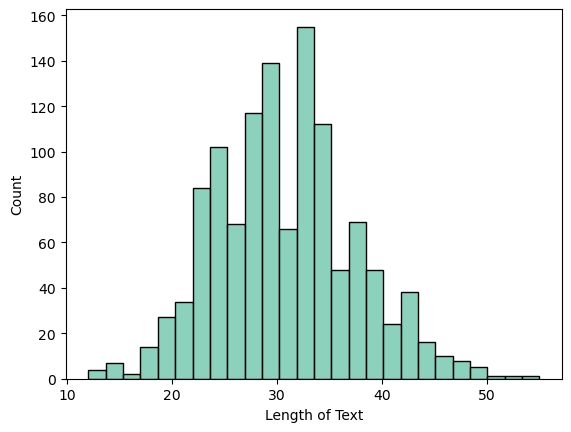

In [8]:
# check the length of text
text_length = dat['text'].apply(lambda x: len(x.split(' ')))

sns.histplot(text_length)
plt.xlabel('Length of Text')
plt.show()

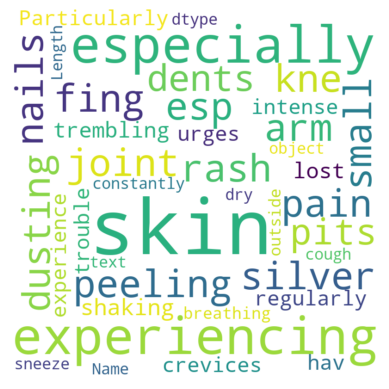

In [9]:
# wordcloud of symptom texts

stop_words = set(stopwords.words('english'))
# add some stop words
stop_words.update(["I've", "I'm", "like"])

wordcloud = WordCloud(width = 800, 
                      height = 800, 
                      background_color ='white', 
                      stopwords=stop_words, 
                      min_font_size = 8).generate(str(dat['text']))

# display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Data preprocessing

## Label encoding

Before modeling, we need to encode the disease into numbers. Here I use the LabelEncoder from sklearn. You can also tokenize the disease and use the tokenizer to encode the disease, but you should be careful that some diseases contain more than one word and they could share the same words.

In [10]:
def label_encode(labels):
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)
    label_sequences = label_encoder.transform(labels)
    return label_sequences

# test: random sample 5 labels in dat and corresponding sequences
for i in np.random.randint(0, len(dat['label']), 5):
    print(dat['label'][i], label_encode(dat['label'])[i])

dat['label_encoded'] = label_encode(dat['label'])

Migraine 13
drug reaction 20
Varicose Veins 17
diabetes 19
diabetes 19


## Split data into train and validation

In [11]:
train_ratio = 0.8
# sample 80% of the data for training and 20% for validation for each label
train = dat.groupby('label_encoded', group_keys=False).apply(lambda x: x.sample(frac=train_ratio, random_state=42))
val = dat.drop(train.index)

train_texts = train['text'].values
train_labels = train['label_encoded'].values
val_texts = val['text'].values
val_labels = val['label_encoded'].values

train_texts.shape, train_labels.shape, val_texts.shape, val_labels.shape

((960,), (960,), (240,), (240,))

## Remove stop words
We have converted the disease label to integer. Now we will deal with the symptom texts to remove stop words that are provide little information, meanwhile generating tokens.

In [12]:
def remove_stopwords(texts):
    # first remove all punctuations 
    words = [re.split(r'[ ,.]+', text) for text in texts]

    # remove space and make all words lower case
    words = [[word.lower() for word in text if word != ''] for text in words]

    # remove stop words using nltk (or you can use your own stop words, see below)
    stop_words = set(stopwords.words('english'))

    words = [[word for word in text if word.lower() not in stop_words] for text in words]
    return words

print(train_texts[0])
# test the function
print(remove_stopwords(train_texts)[0])

A nasty rash has just appeared on my skin. Blackheads and pimples packed with pus are everywhere. Additionally, my skin has been extremely sensitive.
['nasty', 'rash', 'appeared', 'skin', 'blackheads', 'pimples', 'packed', 'pus', 'everywhere', 'additionally', 'skin', 'extremely', 'sensitive']


In [13]:
# # alternative way to remove stop words you defined

# def remove_stopwords(sentence):
#     stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
#     sentence = sentence.lower()
#     sentence_list = sentence.split()
#     sentence_list = [word for word in sentence_list if word not in stopwords]
#     return ' '.join(sentence_list)


## Visualize the size of words

We can find that the length of symptom description is shortened after stop words removal:

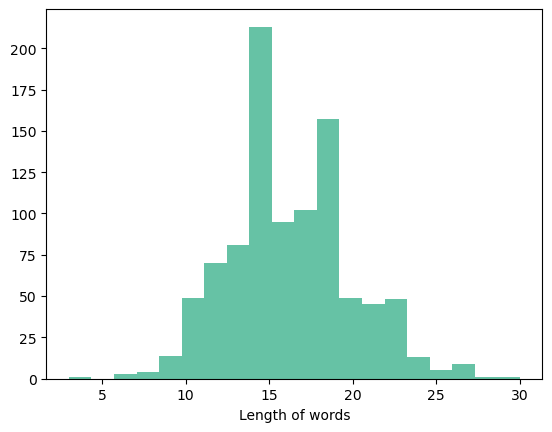

In [14]:
words_length = [len(w) for w in remove_stopwords(train_texts)]
plt.hist(words_length, bins=20)
plt.xlabel('Length of words')
plt.show()

## Tokenization and padding

In [15]:
# make a tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

def tokenize_and_pad(words, tokenizer, max_len=50):
    # convert the text to sequences of integers
    sequences = tokenizer.texts_to_sequences(words)
    # pad the sequences using the maxlen to make all sequences the same length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences

# test the function
tokenize_and_pad(train_texts, tokenizer)[0]

array([  5, 287,  46,  13, 177, 562,  22,   3,  16, 133,   2,  92, 637,
        24, 134,  18, 400,  89,   3,  16,  13,   6,  98, 269,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Apply preprocessing to train and validation data
Note that the train and validation data should be preprocessed in the same way, especially using the same tokenizer.

In [16]:
train_sequences = tokenize_and_pad(remove_stopwords(train_texts), tokenizer)
train_labels = train_labels.reshape(-1, 1)

val_sequences = tokenize_and_pad(remove_stopwords(val_texts), tokenizer)
val_labels = val_labels.reshape(-1, 1)

print('train_sequences shape: ', train_sequences.shape)
print('train_labels shape: ', train_labels.shape)
print('val_sequences shape: ', val_sequences.shape)
print('val_labels shape: ', val_labels.shape)

train_sequences shape:  (960, 50)
train_labels shape:  (960, 1)
val_sequences shape:  (240, 50)
val_labels shape:  (240, 1)


# Build and train model

There are many model alternatives to predict a label from texts, such as Embedding, Embedding + CNN,  Embedding + LSTM, BERT, etc. I will try each of them and compare the performance using the validation data.


In [17]:
# define a function to visualize the training and validation loss and accuracy
def plot_graphs(history, metric):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(history.history[metric])
    ax.plot(history.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.title(metric)
    plt.show()

max_length = 50

Before building models, we need to clarify the input and output of the model. The input is the symptom description with a maximum length of 50 words. The output is one of the 24 diseases. For the neural network, the input shape is (None, 50) and the output shape is (None, 24)

## Embedding Neural Network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           256000    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 24)                792       
                                                                 
Total params: 260,920
Trainable params: 260,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
30/30 [==============================] - 1s 15ms/step - loss: 3.1709 - accuracy: 0.0979 - val_loss: 3.156

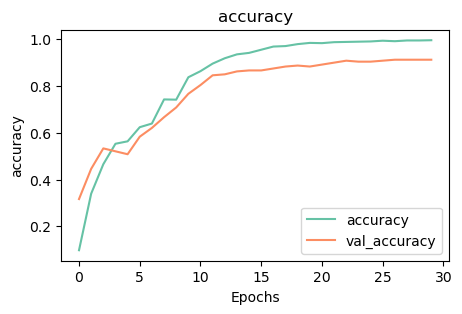

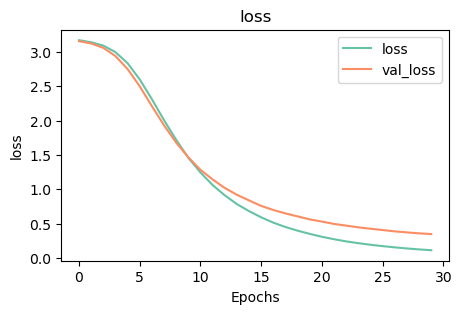

In [18]:
# build the model with embedding layer
model_embed = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 128, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(24, activation='softmax')])

model_embed.summary()

model_embed.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
history = model_embed.fit(train_sequences, train_labels, epochs=30, validation_data=(val_sequences, val_labels))
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [19]:
# model validation accuracy
model_embed.evaluate(val_sequences, val_labels)

8/8 [==============================] - 0s 3ms/step - loss: 0.3496 - accuracy: 0.9125


[0.34964048862457275, 0.9125000238418579]

## Convolutional Neural Network

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           256000    
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 conv1d (Conv1D)             (None, 46, 128)           82048     
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                      

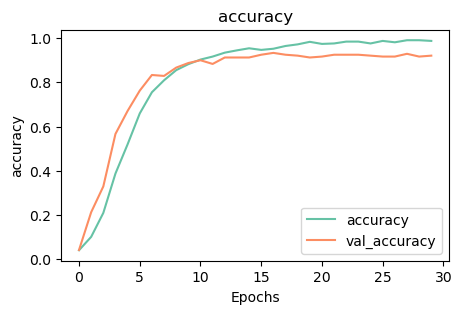

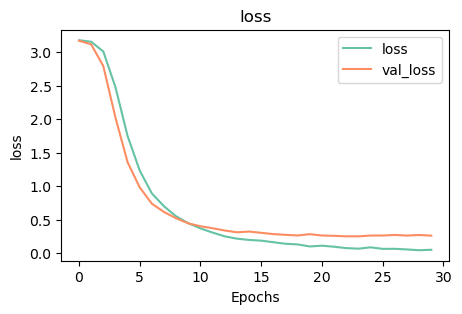

In [20]:
# build the model with convolutional layer, be careful with overfitting
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 128, input_length=max_length),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(24, activation='softmax')])
model_conv.summary()

model_conv.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
history = model_conv.fit(train_sequences, train_labels, epochs=30, validation_data=(val_sequences, val_labels))

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [21]:
# model validation accuracy
model_conv.evaluate(val_sequences, val_labels)

8/8 [==============================] - 0s 5ms/step - loss: 0.2632 - accuracy: 0.9208


[0.26315852999687195, 0.9208333492279053]

## LSTM

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 128)           256000    
                                                                 
 dropout_3 (Dropout)         (None, 50, 128)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                      

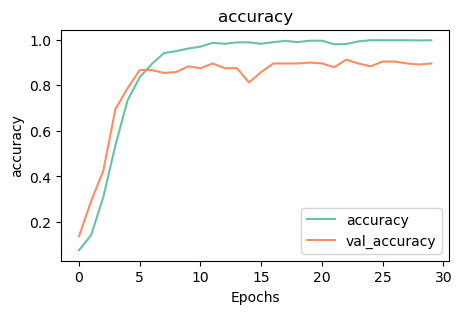

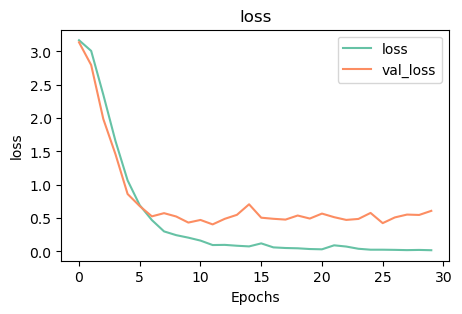

In [22]:
# build the model with LSTM layer, be careful with overfitting
tf.random.set_seed(42)
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 128, input_length=max_length),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(24, activation='softmax')])
model_lstm.summary()

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
history = model_lstm.fit(train_sequences, train_labels, epochs=30, validation_data=(val_sequences, val_labels))

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [23]:
# model validation accuracy
model_lstm.evaluate(val_sequences, val_labels)

8/8 [==============================] - 0s 13ms/step - loss: 0.6091 - accuracy: 0.8958


[0.609103262424469, 0.8958333134651184]

## Transformer

I found a solution using BERT which works very well. Check out [this notebook](https://www.kaggle.com/code/faizalkarim/pretrained-bert-98-8/notebook)!

# Model Evaluation & Prediction

From the above, we can find that the validation accuracy of both CNN and embedding models are the highest, even though all models perform well with the validation accuracy above 85%. Also, all models show higher accuracy on the training set than the validation set, which indicates mild overfitting. I have tried to add dropout layers to the models. Further improvement can be done by adding regularization and tuning the hyperparameters.

Here I will use the CNN model to predict the disease from the symptom description.

In [24]:
# make some text to describe the symptoms

test_text = ['My skin is dry and itchy. I can see some rashes on my skin and my face turns red easily.']
# test_text = ['My stomach hurts and I feel nauseous. I have diarrhea and I feel weak.']
# test_text = ['red, scaly patches on the skin, itching, dryness, cracking, and bleeding of the skin, swollen and stiff joints, and nail abnormalities.']

print(f"The symptom is: \n {test_text[0]}")

# preprocess the text using the function we defined above
test_sequences = tokenize_and_pad(remove_stopwords(test_text), tokenizer)

# predict the label
test_pred = model_conv.predict(test_sequences)

# get the top 3 disease labels with the highest probability
top_3 = np.argsort(test_pred[0])[-3:][::-1]

label_encoder = LabelEncoder().fit(dat['label'])
# map the label sequence to the label name
print('The top 3 possible diseases are: ', label_encoder.inverse_transform(top_3))

The symptom is: 
 My skin is dry and itchy. I can see some rashes on my skin and my face turns red easily.
1/1 [==============================] - 0s 130ms/step
The top 3 possible diseases are:  ['Psoriasis' 'drug reaction' 'allergy']


# Conclusion

In this notebook, I have explored how to infer disease from symptoms using language models.

I have shown how to preprocess text data and build neural network models.
I have tried three different neural network models: embedding neural network, convolutional neural network, and LSTM. I have evaluated the models using the validation data and found that all models perform well with the validation accuracy over 85%. 

I finally used the CNN model to predict the disease from the symptom description, considering its high accuracy (over 92%) and low overfitting.

The overfitting issues can be further improved by adding regularization and tuning the hyperparameters.


# Outlook
What can be improved in the future?
- I will definitely try other methods like MLPClassifier and transformer models some time later.
- We can see that there are still words in the symptom description that are not relevant to the disease. Is there a way to remove them?
- With the trained model, we can build an interactive web app to predict the disease from the symptom description. This can be very helpful for patients to get a quick diagnosis.